In [1]:
import MetaTrader5 as mt5
import pytz
from datetime import datetime
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas_ta as ta
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow import keras
plt.style.use('fivethirtyeight')

# Read data from csv file

In [2]:
# df = pd.read_csv('EURUSD-2015.csv')
# df.head()
# df.to_csv('EURUSD-2015.csv',index=False)

# Read data from MT5

In [3]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

account = 51413020
login = mt5.login(account,password="8R3gA5RO5")


timezone = pytz.timezone("Etc/UTC")
year = datetime.now().year
month = datetime.now().month
day = datetime.now().day
hour = datetime.now().hour
minute = datetime.now().minute
second = datetime.now().second


utc_from=datetime(2018,1,1,tzinfo=timezone)
utc_to=datetime(year,month,day,hour, minute, second , tzinfo=timezone)
rates=mt5.copy_rates_range("XAUUSD",mt5.TIMEFRAME_H1,utc_from,utc_to)

df = pd.DataFrame(rates)
df['time']=pd.to_datetime(df['time'], unit='s')
df=df[['time','open','high','low','close','tick_volume']]
df


,time,open,high,low,close,tick_volume
0,2018-01-02 09:00:00,1309.94,1310.28,1308.79,1309.42,17150
1,2018-01-02 10:00:00,1309.41,1310.89,1308.52,1310.25,19323
2,2018-01-02 11:00:00,1310.24,1312.33,1310.00,1312.24,17991
3,2018-01-02 12:00:00,1312.25,1312.88,1310.12,1311.86,18883
4,2018-01-02 13:00:00,1311.87,1312.33,1310.14,1310.19,12195
...,...,...,...,...,...,...
29506,2022-12-30 16:00:00,1821.77,1825.24,1817.93,1819.06,12428
29507,2022-12-30 17:00:00,1819.04,1819.54,1814.27,1818.44,12528
29508,2022-12-30 18:00:00,1818.44,1818.81,1814.32,1816.21,7789
29509,2022-12-30 19:00:00,1816.21,1824.01,1816.21,1823.91,7199


In [27]:
df['RSI']=ta.rsi(df.close, length=15)
df['EMAF']=ta.ema(df.close, length=10)
df['EMAM']=ta.ema(df.close, length=15)
df['EMAS']=ta.ema(df.close, length=20)
df['Target']=df['close'].shift(-1)
df=df.dropna()
df
df.to_csv('XAUUSD-2018.csv',index=False)

C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_15068\3484932827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI']=ta.rsi(df.close, length=15)
C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_15068\3484932827.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df['EMAF']=ta.ema(df.close, length=10)
C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_15068\3484932827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

# Deep learning by OHLC price

In [5]:
data = df.filter(['open','high','low','close','tick_volume','RSI','EMAF','EMAM','EMAS','Target'])
dataset = data.values

In [6]:
training_data_len = math.ceil(len(dataset)*0.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [7]:
scaled_data.shape

(29491, 10)

In [8]:
training_data_len

23593

In [9]:

n = 12 # count 12 last price
traning_data = scaled_data[0:training_data_len,:]
test_data = scaled_data[training_data_len - n : , :]


In [10]:
x_train = []
y_train = []

In [11]:
for i in range(n,len(traning_data)):
    x_train.append(traning_data[i-n : i , :9])
    y_train.append(traning_data[i,9]) # 9 is index of Target column

x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
x_test = []
y_test=dataset[training_data_len :,9]

for i in range(n,len(test_data)):
    x_test.append(test_data[i-n : i , :9])
    

x_test, y_test = np.array(x_test), np.array(y_test)

In [13]:
y_train = np.reshape(y_train,(y_train.shape[0],1,1))
y_test = np.reshape(y_test,(y_test.shape[0],1,1))

In [14]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(23581, 12, 9)
(23581, 1, 1)
(5898, 12, 9)
(5898, 1, 1)


In [15]:
model = Sequential([
    keras.layers.LSTM(150,activation='selu',return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])),
    keras.layers.LSTM(100,activation='selu',return_sequences=False),
    keras.layers.Dense(25,activation='selu'),
    keras.layers.Dense(1)   
])

In [16]:
model.compile(loss='mean_squared_error',optimizer='sgd')

In [17]:
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint("model_cb.h5",
#                                                          save_best_only=True)
# earlystopping_callback = keras.callbacks.EarlyStopping(patience=10,
#                              restore_best_weights=True)

In [18]:
# model.fit(x_train,y_train,epochs=2,
#           validation_split=0.2,
#           batch_size=1,
#           callbacks=[model_checkpoint_callback, earlystopping_callback])

hist=model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=1)

Epoch 1/50
18864/18864 [==============================] - 111s 6ms/step - loss: 3.2138e-04 - val_loss: 5.0191e-05
Epoch 2/50
18864/18864 [==============================] - 109s 6ms/step - loss: 8.8252e-05 - val_loss: 3.9572e-05
Epoch 3/50
18864/18864 [==============================] - 107s 6ms/step - loss: 7.8426e-05 - val_loss: 6.0098e-04
Epoch 4/50
18864/18864 [==============================] - 107s 6ms/step - loss: 7.1405e-05 - val_loss: 3.9460e-05
Epoch 5/50
18864/18864 [==============================] - 109s 6ms/step - loss: 6.5003e-05 - val_loss: 3.6660e-05
Epoch 6/50
18864/18864 [==============================] - 107s 6ms/step - loss: 6.2533e-05 - val_loss: 4.2531e-05
Epoch 7/50
18864/18864 [==============================] - 108s 6ms/step - loss: 5.8474e-05 - val_loss: 3.6671e-05
Epoch 8/50
18864/18864 [==============================] - 109s 6ms/step - loss: 5.7386e-05 - val_loss: 4.9994e-05
Epoch 9/50
18864/18864 [==============================] - 109s 6ms/step - loss: 5.4674e-

In [19]:
# model.save("model_saving.h5")

In [20]:
# model_f_reg = keras.models.load_model("model_saving.h5")

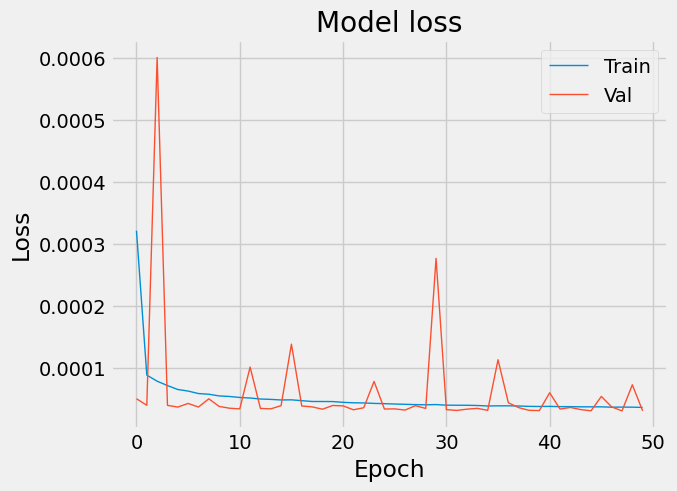

In [21]:
plt.plot(hist.history['loss'],linewidth=1)
plt.plot(hist.history['val_loss'],linewidth=1)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [22]:
model.evaluate(x_test, y_test, verbose=0)

3250876.5

In [23]:
prediction = model.predict(x_test)

predict_dataset_like = np.zeros(shape=(len(prediction),10))
predict_dataset_like[:,0] = prediction[:,0]
prediction = scaler.inverse_transform(predict_dataset_like)[:,0]
predict_dataset_like.shape

185/185 [==============================] - 2s 11ms/step


(5898, 10)

In [24]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['prediction'] = prediction

C:\Users\Mojtaba\AppData\Local\Temp\ipykernel_15068\2864968302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['prediction'] = prediction


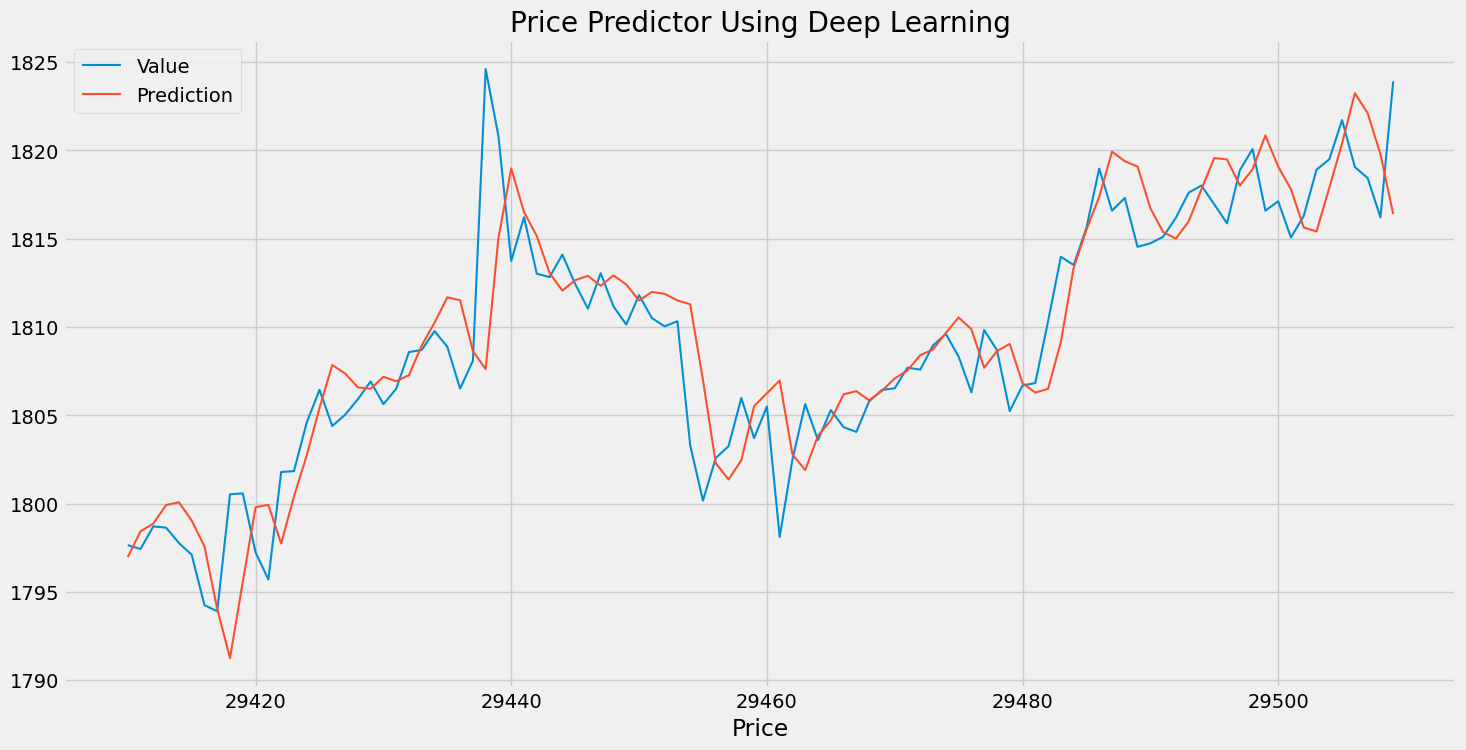

In [25]:
plt.figure(figsize=(16,8))
plt.title('Price Predictor Using Deep Learning')
plt.xlabel('Date')
plt.xlabel('Price')
# plt.plot(train['close'][-100:],linewidth=1.5)
plt.plot(valid[['close','prediction']][-100:],linewidth=1.5)
plt.legend(['Value', 'Prediction'])
plt.show()

In [26]:
pre_x=[]

for i in range(n):
    pre_x.append(dataset[i-n,:8])
    
pre_x = np.array(pre_x)
pre_x = pre_x.reshape(1,pre_x.shape[0],pre_x.shape[1])
